In [0]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
root_dir = "/content/gdrive/My Drive/"
base_dir = root_dir + 'tensor_flow/'

In [2]:
!pip install --upgrade tensorflow

     |████████████████████████████████| 421.8MB 40kB/s 
     |████████████████████████████████| 3.9MB 26.8MB/s 
     |████████████████████████████████| 450kB 52.0MB/s 
ERROR: tensorflow-federated 0.12.0 has requirement tensorflow-addons~=0.7.0, but you'll have tensorflow-addons 0.8.3 which is incompatible.
  Found existing installation: tensorboard 1.15.0
    Uninstalling tensorboard-1.15.0:
      Successfully uninstalled tensorboard-1.15.0
  Found existing installation: tensorflow-estimator 1.15.1
    Uninstalling tensorflow-estimator-1.15.1:
      Successfully uninstalled tensorflow-estimator-1.15.1
  Found existing installation: tensorflow 1.15.0
    Uninstalling tensorflow-1.15.0:
      Successfully uninstalled tensorflow-1.15.0


In [0]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import os

In [0]:
dataset = base_dir + 'dataset/'

In [0]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [0]:
image_paths = list(paths.list_images(dataset))
print(image_paths)
data = []
labels = []
for image_path in image_paths:
  label = image_path.split(os.path.sep)[-2]
  image = cv2.imread(image_path)
  image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
  image = cv2.resize(image, (224, 224))

  data.append(image)
  labels.append(label)


In [0]:
data = np.array(data) / 255.0
labels = np.array(labels)

In [18]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
print(labels)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [0]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.20, stratify=labels, random_state=42)

train_augment = ImageDataGenerator(rotation_range=15, fill_mode="nearest")

In [0]:
base_model = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

head_model = base_model.output
head_model = AveragePooling2D(pool_size=(4, 4)) (head_model)
head_model = Flatten(name="flatten") (head_model)
head_model = Dense(64, activation="relu") (head_model)
head_model = Dropout(0.5) (head_model)
head_model = Dense(2, activation="softmax") (head_model)

model = Model(inputs=base_model.input, outputs=head_model)

for layer in base_model.layers:
  layer.trainable = False

In [21]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=['accuracy'])

head = model.fit_generator(train_augment.flow(trainX, trainY, batch_size=BS), 
                          steps_per_epoch=len(trainX) // BS,
                          validation_data=(testX, testY), 
                          validation_steps=len(testX) // BS,
                          epochs=EPOCHS)

  ...
    to  
  ['...']
Train for 5 steps, validate on 10 samples
Epoch 1/25
5/5 [==============================] - 7s 1s/step - loss: 1.0424 - accuracy: 0.4000 - val_loss: 0.4774 - val_accuracy: 1.0000
Epoch 2/25
5/5 [==============================] - 1s 112ms/step - loss: 0.7444 - accuracy: 0.5000 - val_loss: 0.4729 - val_accuracy: 1.0000
Epoch 3/25
5/5 [==============================] - 1s 111ms/step - loss: 0.7803 - accuracy: 0.4750 - val_loss: 0.4723 - val_accuracy: 1.0000
Epoch 4/25
5/5 [==============================] - 1s 110ms/step - loss: 0.7004 - accuracy: 0.5250 - val_loss: 0.4669 - val_accuracy: 1.0000
Epoch 5/25
5/5 [==============================] - 1s 115ms/step - loss: 0.6304 - accuracy: 0.6250 - val_loss: 0.4623 - val_accuracy: 1.0000
Epoch 6/25
5/5 [==============================] - 1s 111ms/step - loss: 0.6263 - accuracy: 0.6000 - val_loss: 0.4607 - val_accuracy: 1.0000
Epoch 7/25
5/5 [==============================] - 1s 113ms/step - loss: 0.6368 - accuracy: 0.550

In [23]:
pred_idxs = model.predict(testX, batch_size=BS)
pred_idxs = np.argmax(pred_idxs, axis=1)
print(classification_report(testY.argmax(axis=1), pred_idxs, target_names=lb.classes_))

              precision    recall  f1-score   support

       covid       0.83      1.00      0.91         5
      normal       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10



In [24]:
cm = confusion_matrix(testY.argmax(axis=1), pred_idxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[5 0]
 [1 4]]
acc: 0.9000
sensitivity: 1.0000
specificity: 0.8000


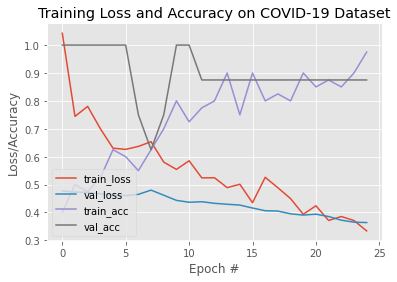

In [26]:
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), head.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), head.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), head.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), head.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(base_dir)

In [0]:
model.save(base_dir + 'covid19.model', save_format='h5')